Loading data...

Training base models...
Training XGBoost...
Training Random Forest...
Training LightGBM...
[LightGBM] [Info] Number of positive: 250000, number of negative: 190833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 440833, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567108 -> initscore=0.270062
[LightGBM] [Info] Start training from score 0.270062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

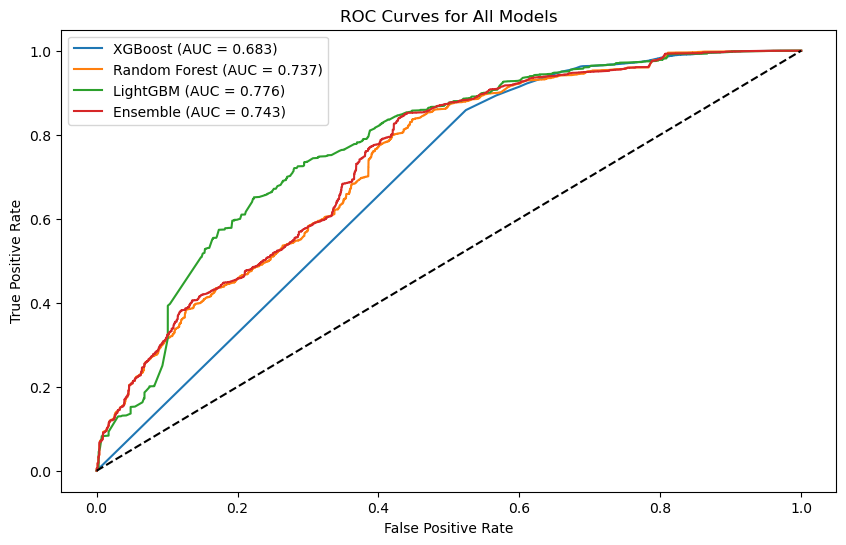

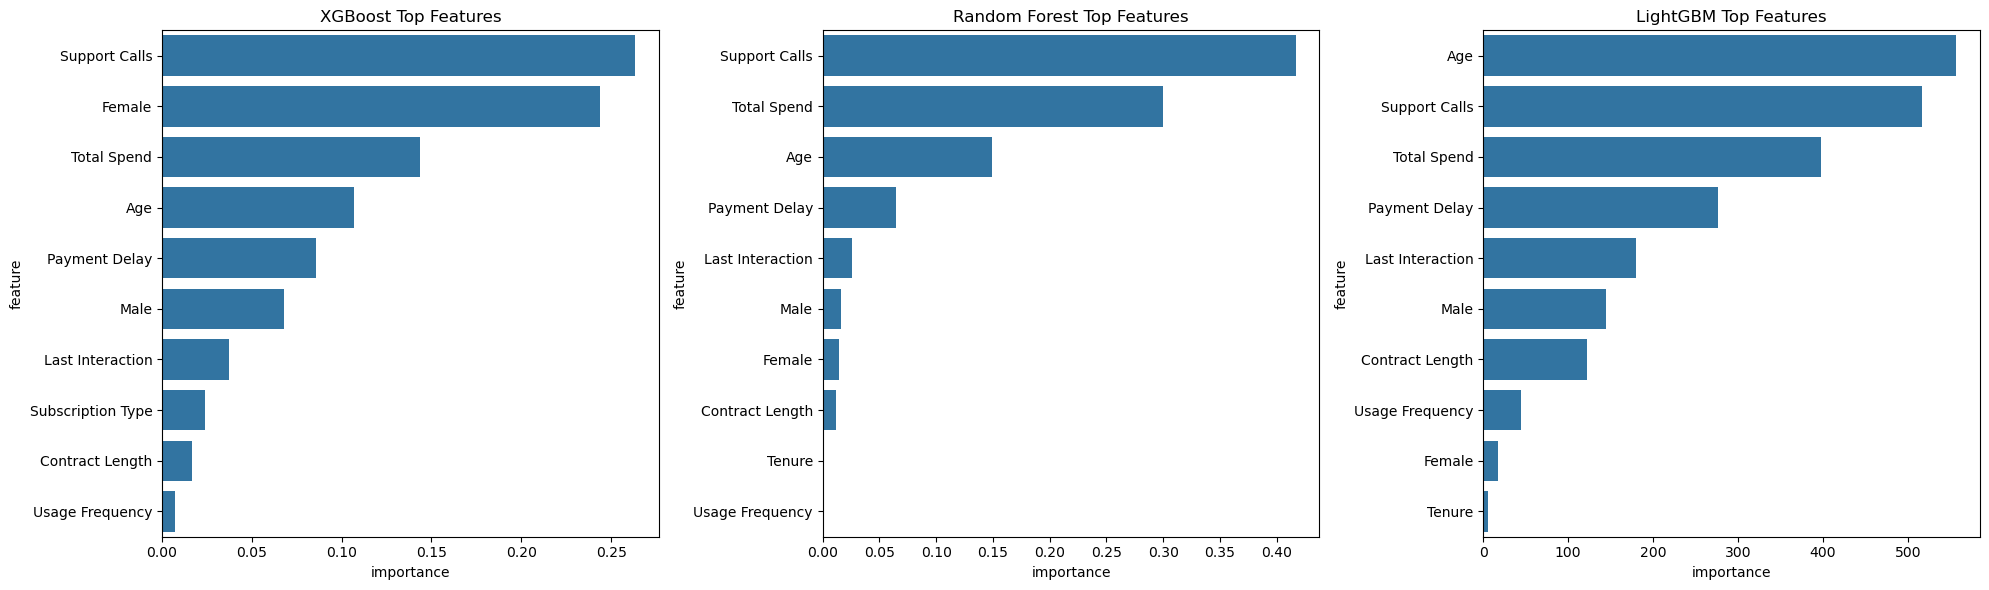

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from sklearn.metrics import roc_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


print("Loading data...")
train_data = pd.read_csv('../Dataset/cleaned_customer_churn_dataset_training.csv')
test_data = pd.read_csv('../Dataset/cleaned_customer_churn_dataset_testing.csv')

# Separate features and target
X_train = train_data.drop(['CustomerID', 'Churn'], axis=1)  
y_train = train_data['Churn']
X_test = test_data.drop(['CustomerID', 'Churn'], axis=1)   
y_test = test_data['Churn']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize base models
xgb_model = xgb.XGBClassifier(
    max_depth=2,
    learning_rate=0.3,
    n_estimators=500,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.7,
    reg_lambda=2.0,
    min_child_weight=5,
    gamma=1,
    tree_method='hist',
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=15,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2.0,
    min_child_samples=10,
)

# Train base models
print("\nTraining base models...")
print("Training XGBoost...")
xgb_model.fit(X_train_scaled, y_train)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)

print("Training LightGBM...")
lgb_model.fit(X_train_scaled, y_train)

# Get predictions from each model
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
lgb_pred_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Weighted ensemble predictions
weights = [0.4, 0.3, 0.3]  # Weights for XGBoost, Random Forest, and LightGBM
ensemble_pred_proba = (weights[0] * xgb_pred_proba +
                      weights[1] * rf_pred_proba +
                      weights[2] * lgb_pred_proba)

ensemble_predictions = (ensemble_pred_proba > 0.5).astype(int)

# Plot ROC curves
plt.figure(figsize=(10, 6))

def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_pred_proba):.3f})')

plot_roc_curve(y_test, xgb_pred_proba, 'XGBoost')
plot_roc_curve(y_test, rf_pred_proba, 'Random Forest')
plot_roc_curve(y_test, lgb_pred_proba, 'LightGBM')
plot_roc_curve(y_test, ensemble_pred_proba, 'Ensemble')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.show()

# Feature importance comparison
def plot_feature_importance_comparison():
    # Get feature importance from each model
    feature_names = X_train.columns
    
    xgb_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    rf_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    lgb_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot top 10 features for each model
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    sns.barplot(data=xgb_importance.head(10), x='importance', y='feature', ax=ax1)
    ax1.set_title('XGBoost Top Features')

    sns.barplot(data=rf_importance.head(10), x='importance', y='feature', ax=ax2)
    ax2.set_title('Random Forest Top Features')

    sns.barplot(data=lgb_importance.head(10), x='importance', y='feature', ax=ax3)
    ax3.set_title('LightGBM Top Features')

    plt.tight_layout()
    plt.show()

plot_feature_importance_comparison()